## VALIDAÇÃO CRUZADA
**Objetivo**: Explorar um algoritmo de aprendizado de máquina para compreender o método de validação cruzada e as métricas utilizadas para avaliar um modelo de classificação. Vamos iniciar pela importação das bibliotecas.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

**(1) Geração de um dataset artificial**

[Make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html?highlight=make_moons#sklearn.datasets.make_moons) gera dataset bidimensional com duas features de entrada: x0 e x1 e uma classe de saída binária (`y E {0, 1}`). Assim, podemos obter duas *luas* ou nuvens de pontos, cada qual pertencente a uma classe (0 ou 1). As nuvens podem apresentar sobreposição (ou não) em função do parâmetro *noise*.
Quando trabalhamos com amostras ou exemplos positivos e negativos de uma classe, chamamos de aprendizado de conceito.

In [ ]:
# make_moons serve para gerar datasets sintéticos para testes.
# Make moons gera duas regioes circulares de exemplos positivos e negativos

# shuffle: boolean - embaralhar ou nao as amostras
# noise: desvio padrao de ruido Gaussiano
# random_star: se for int produz saidas identicas quando invocado diversas vezes
# Xm é um array de duas colunas [x0 x1] por m linhas = n_samples
Xm, ym = make_moons(n_samples=1000, noise=0.35, random_state=42)
Xy = [[x0, x1, y] for x0, x1, y in zip(Xm[:,0], Xm[:,1], ym)]

# transforma os arrays Xm e ym em um dataframe do pandas
# df contem o dataset original que será utilizado para treino/validação e testes
df = pd.DataFrame(Xy, columns = ['x0','x1','y'])
print("Amostras iniciais do dataframe")
print(df.head(3)) # imprime 3 amostras do dataframe

Amostras iniciais do dataframe
         x0        x1  y
0 -0.201962  0.634261  1
1  1.308599 -0.226832  1
2  0.687057  0.353635  1


**(2) Plotar as amostras**

Observar que as amostras formam duas regiões circulares com sobreposição definida pelo argumento *noise* em *make_moons*.

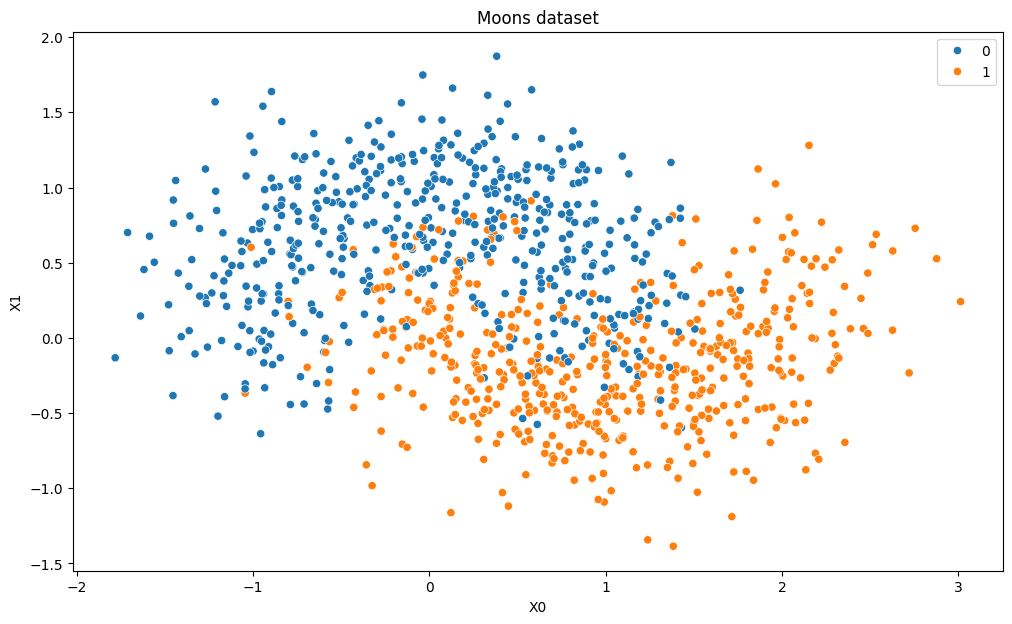

In [ ]:
# plot data
plt.figure(figsize=(12,7))

gr = sns.scatterplot(data=df, x="x0", y="x1", hue="y")
gr.set_title("Moons dataset")
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()
plt.show()

**(3) Validação cruzada**

É um método para treinar/validar o modelo em treinamento para evitar sua sobreadaptação (*overfitting*) às amostras de treinamento.

SciKit possibilita separar o dataset em partes justamente para evitar este problema. Vamos fracionar o dataset em duas partes:
1.   treinamento e validação
2.   teste cego: com dados não utilizados em treinamento/validação. Caso você tenha um dataset só para testes cego, não precisa fazer este split.


**Parêmetros importantes**:
* *test_size*: qual fração do dataset será reservado para testes (entre 20-30%)
* *shuffle*: boolean; embaralha ou não antes de dividir (recomendável true)

Vamos fazer o fracionamento do dataset manualmente com a função *train_test_split* do seguinte modo:
* 75% para treinamento/validação e
* 25% para testes cegos.


(mais detalhes na documentação: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split))


In [ ]:
## Dividir o dataset em treinamento/validação e teste cego
## É usual designar a entrada por X e a saída por y
X_train, X_test, y_train, y_test = train_test_split(Xm, ym, test_size=0.25, shuffle=True)
print(f"Tamanho total do dataset: {len(Xm)}\n")
print(f"Dados de treinamento X ({len(X_train)}):\n{X_train[:3]} ...")
print(f"Dados de treinamento y:({len(y_train)})\n {y_train[:3]} ...")
print("---")
print(f"Dados de teste   X ({len(X_test)}):\n{X_test[:3]} ...")
print(f"Dados de teste   y:({len(y_test)})\n {y_test[:3]} ...")

Tamanho total do dataset: 1000

Dados de treinamento X (750):
[[ 0.79417972 -0.58232286]
 [-1.55982138  0.50318665]
 [-0.34143228  1.05438142]] ...
Dados de treinamento y:(750)
 [1 0 0] ...
---
Dados de teste   X (250):
[[ 1.34855369  0.42837533]
 [ 1.49708428 -0.58826801]
 [ 1.71505565 -1.18866599]] ...
Dados de teste   y:(250)
 [0 1 1] ...


**(4) Experimento**

Um experimento consiste em utilizar *n parametrizações* diferentes do algoritmo em k *folds* (fracionamentos) e comparar cada parametrização a fim de escolher a melhor delas.

No nosso caso, vamos fazer [8 parametrizações diferentes](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) para a árvore de decisão que resulta de todas as combinações dos parâmetros abaixo:
* ***criterio***: `entropia` e `gini`
* ***max_depth***: profundidade máxima da árvore: `{2, 4}`
* ***min_samples_leaf***:  número mínimo de amostras por folha; pode acabar descartando ramificações de nós não folha: `{4, 8}`

```
Em cada experimento de treinamento:
   Para cada uma das parametrizações:
        realizar o treinamento/validação para cada fold

Realizar teste cego com melhor modelo aprendido
```

No nosso experimento temos 8 parametrizações = *criterio x opções de max_depth x opções de min_samples_leaf*.

Vamos utilizar o método **K-Fold de validação cruzada** com K=3.

Assim, para cada parametrização, o algoritmo será treinado e validado 3 vezes, totalizando 18 execuções.

Vamos utilizar a função [GridSearchCV](https://colab.research.google.com/drive/1hSrqmmzphUlQRXmA__VMaged20a_tH1f?authuser=2#scrollTo=flNYY1YgSiea&line=11&uniqifier=1) que faz todas as combinações dos parâmetros e, também, a validação cruzada(CV).

**GridSearchCV** produz uma linha com os resultados por parametrização e por fold.

Há várias métricas de comparação que podem ser utilizadas para determinar o melhor modelo (ver opções de **score** neste [link](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)). No exemplo, vamos utilizar o *f1_weighted* (média harmônica entre precisão e recall ponderada pela numero de exemplos por classe).

`f1 = 2 * (precision * recall) / (precision + recall)`

---



In [ ]:
# Parameters' definition
parameters = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [2, 4],
    'min_samples_leaf': [4, 8]
}

# instantiate model
# random_state = 42 to be deterministic
model = DecisionTreeClassifier(random_state=42)

# grid search using cross-validation
# cv = 3 is the number of folds
# scoring = 'f' the metric for chosing the best model
clf = GridSearchCV(model, parameters, cv=3, scoring='f1_weighted', verbose=4)
clf.fit(X_train, y_train)

# the best tree according to the f1 score
best = clf.best_estimator_
print("\n* Melhor classificador *")
print(clf.best_estimator_)
print("\n* Parametros do classificador *")
print(clf.best_estimator_.get_params())


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END criterion=entropy, max_depth=2, min_samples_leaf=4;, score=0.884 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, min_samples_leaf=4;, score=0.880 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, min_samples_leaf=4;, score=0.872 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, min_samples_leaf=8;, score=0.884 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, min_samples_leaf=8;, score=0.880 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, min_samples_leaf=8;, score=0.872 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, min_samples_leaf=4;, score=0.884 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, min_samples_leaf=4;, score=0.880 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, min_samples_leaf=4;, score=0.872 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, min_samples_leaf=8;, s

O melhor modelo pode variar de execução para execução já que os dados de treinamento/validação são embaralhados. Por isso a importância de repetirmos várias vezes o experimento até que um modelo aprendido domine os demais.



**(5) Testar o modelo aprendido**

Agora, é possível rodar o modelo aprendido com os dados de teste cego (reservados anteriormente) e verificarmos as métricas de classificação.

Se a acurácia do treinamento/validação estiver muito maior do que a do teste, é um indício de que o modelo está sobreadaptado.


In [ ]:
# Predicoes

# Com dados do treinamento
y_pred_train = best.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train) * 100
print(f"Acuracia com dados de treino: {acc_train:.2f}%")

# com dados de teste (nao utilizados no treinamento/validacao)
y_pred_test = best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test) * 100
print(f"Acuracia com dados de teste: {acc_test:.2f}%")

Acuracia com dados de treino: 88.93%
Acuracia com dados de teste: 86.40%


## ÁRVORE DE DECISÃO (MODELO APRENDIDO)

Agora vamos visualizar a árvore de melhor desempenho e algumas métricas para avaliar classificadores:
- matriz de confusão,
- precisão,
- recall e
- f-measure.

Na figura abaixo, observe em cada nó:
* **Xi <= valor** : condição para uma amostra ser classificada em um ramo da árvore
* **entropy**: valor da entropia para o nó (nós folhas normalmente = zero)
* **value**: [amostras da classe 0, amostras da classe 1]
* **class**: mostra a classe mais numerosa do nó

Os valores apresentados são do treinamento/validação.

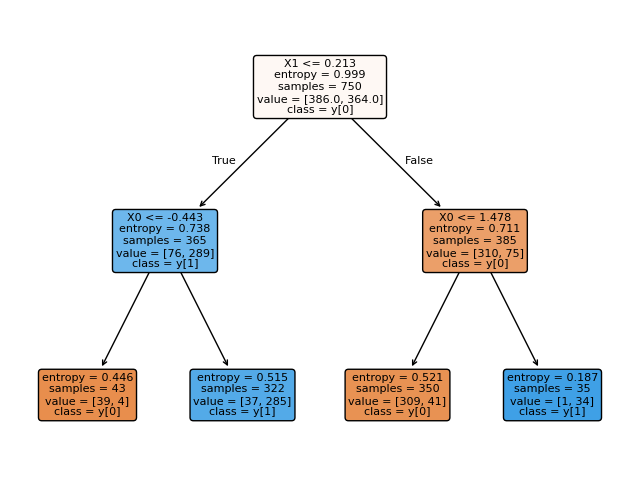

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(8, 6))
tree.plot_tree(best, feature_names=["X0", "X1"], filled=True, rounded=True, class_names=True, fontsize=8)
plt.show()

Vamos ver como esta árvore particiona o espaço de entradas para os dados de teste cego. Também, observe as classificações preditas.

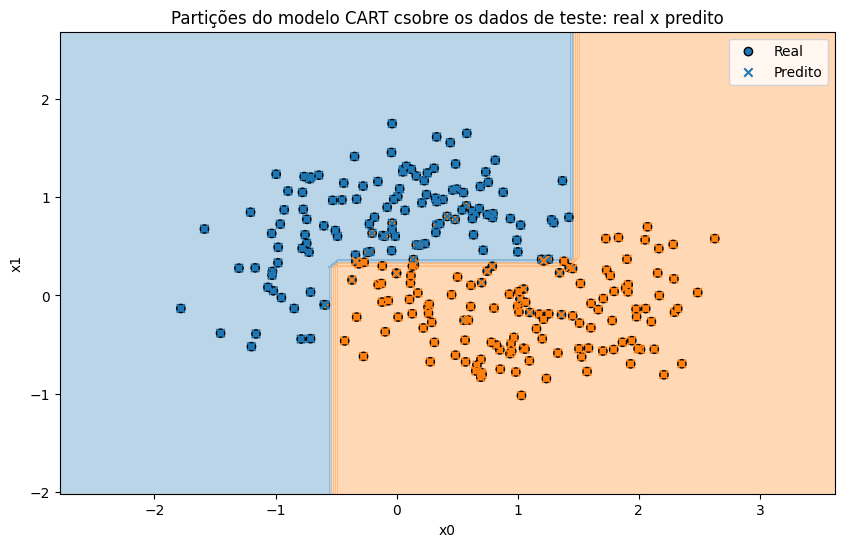

In [ ]:
from matplotlib.colors import ListedColormap

# Mapa de cores azul e laranja
cmap_custom = ListedColormap(["#1f77b4", "#ff7f0e"])  # Azul para 0, laranja para 1

# Malha para o espaço de características - necessárias para o contourf
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Prediz a classe para cada ponto na malha para visualizar as regiões de decisão (os separadores)
Z = best.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as partições no espaço de entrada
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_custom)  # Partições da árvore com azul e laranja

# Plota os dados de teste com as classes reais e as previsões
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', cmap=cmap_custom, label='Real')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, marker='x', cmap=cmap_custom, label='Predito')
plt.xlabel("x0")
plt.ylabel("x1")
plt.title("Partições do modelo CART csobre os dados de teste: real x predito")
plt.legend()
plt.show()



### MÉTRICAS PARA CLASSIFICADORES
Vamos analisar os resultados do teste.

***Matriz de confusão***: mostra o número de classificações corretas na diagonal principal (os verdadeiros positivos, ex. VP 0 são os verdadeiros positivos da classe 0).

Lendo coluna a coluna, as posições que não estão na diagonal principal são os falsos positivos (ex. FP 0 representa os falsos positivos da classe 0).

 `VP 0  |    FP 1`

 `FP 0  |   VP 1`


***Precision***: número de verdadeiros positivos dividido pela soma dos falsos positivos e dos verdadeiros positivos por classe.

Precisão da classe 0:
P0 = VP0 / (VP0 + FP0)

***Recall***: número de verdadeiros positivos de uma classe dividido pela soma dos verdadeiros positivos e falsos negativos. Lendo linha a linha, as posições que não estão na diagonal principal são os falsos negativos (FN):

 `VP 0  |    FN 0`

 `FN 1  |   VP 1`

Recall da classe 0 = VP0 / (VP0 + FN0)

***f1-score***: média harmônica entre precision e recall.

Todas estas métricas podem ser ponderadas pelo número de amostras de cada classe.
   

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       121
           1       0.88      0.88      0.88       129

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250



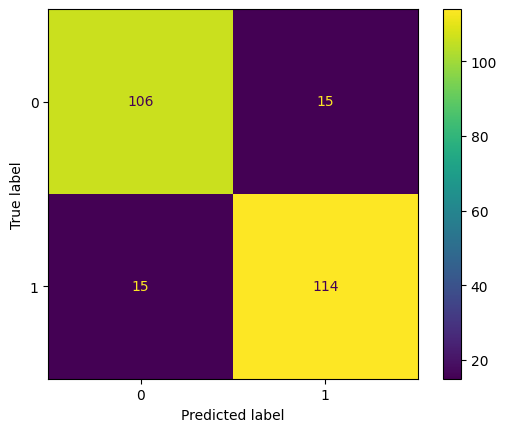

In [ ]:
# Matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test))


---

### **MATRIZ DE CONFUSÃO, PRECISION, RECALL E F1**

Vamos fazer uma matriz com dados estáticos para fins didáticos.
Considere que temos 5 amostras da classe 0 e 7 da classe 1. O classificador acerta:
* 4 da classe 0 (esses são os verdadeiros positivos)
* 5 da classe 1

Lendo coluna a coluna para calcularmos a precisão por classe (rode o código abaixo e veja a figura).

**Precisão = VP / (VP + FP)**
* classe 0, **Precisão, P0** = 4/6 = 0,666
* classe 1, **Precisão, P1** = 5/6 = 0,833
* média: 0,75

Lendo linha a linha para calcularmos o recall por classe:

**Recall = VP / (VP + FN)**
* classe 0, **Recall, R0** = 4/5 = 0,800
* classe 1, **Recall, R1** = 5/7 = 0,714
* média: 0,757
* média ponderada: (5.R0 + 7.R1)/12 = 0,75

**f1**
* classe 0: 2.P0.R0/(P0+R0) = 0,726
* classe 1: 2.P1.R1/(P1+R1) = 0,768
* média: 0,747
* f1 ponderado: (5.f1_0 + 7.f1_1)/12 = 0,7505

**Acuracidade geral**: 9/12 = 0,75


VP = Verdadeiro Positivo; FP = Falso Positivo; FN = Falso Negativo

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.83      0.71      0.77         7

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12



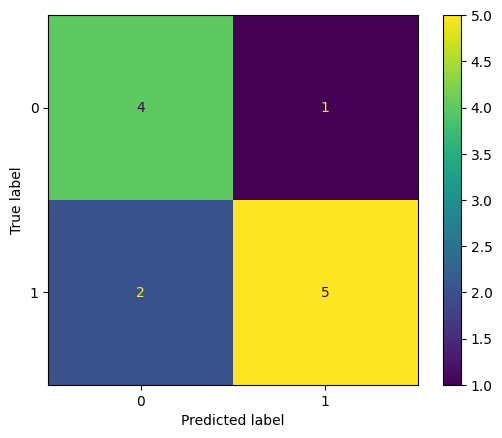

In [ ]:
y_true = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
y_pred = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))

**f i m**